### Data Analysis

@Authors: [Franck Porteous](https://github.com/FranckPrts), [Faith Hunja](https://github.com/faithhunja), [Hannah Krohn](https://github.com/hlili303)

### Set-up

In [1]:
colors = {
    "blue": "#1f77b4",
    "orange": "#ff7f0e",
    "green": "#2ca02c",
    "red": "#d62728",
    "purple": "#9467bd",
    "brown": "#8c564b",
    "pink": "#e377c2",
    "gray": "#7f7f7f",
    "olive": "#bcbd22",
    "cyan": "#17becf"
}

In [23]:
storm_repo = {"Maria":{
  "tg": {"Penuelas, PR": {"lat": 17.972, "lon": -66.762},
        "Isabel Segunda, PR": {"lat": 18.152, "lon": -65.443},
        "Esperanza, PR": {"lat": 18.093, "lon": -65.47},
        "Arecibo, PR": {"lat": 18.48, "lon": -66.702},
        "Mayaguez, PR": {"lat": 18.22, "lon": -67.16},
        "Fajardo, PR": {"lat": 18.333, "lon": -65.633}},

  "tg_precise": {"Penuelas, PR (precise)": {"lat": 17.4, "lon": -66.762},
        "Isabel Segunda, PR (precise)": {"lat": 18.152, "lon": -65.443},
        "Esperanza, PR (precise)": {"lat": 18.093, "lon": -65.47},
        "Arecibo, PR (precise)": {"lat": 18.5, "lon": -66.702},
        "Mayaguez, PR (precise)": {"lat": 18.22, "lon": -67.16},
        "Fajardo, PR (precise)": {"lat": 18.333, "lon": -65.633}}
}}

#### Imports

In [2]:
# Imports

import matplotlib.pyplot as plt
import xarray as xr
import os
import pooch
import tempfile
from pooch import HTTPDownloader
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy import stats

#### Helper function

In [10]:
def plot_time_series_specific_location(
    tg_data_dict, 
    sat_data_dict, 
    event, 
    location,
    xlab:str, ylab:str,
    normalize_zero=True,
    resample_tg=True,
    save_fig=True, plot_fig=True):

    event_tg_data = tg_data_dict.get(event, None)
    event_sat_data = sat_data_dict.get(event, None)
    
    if event_tg_data is None:
        print(f"Event '{event}' not found in the TG dictionary.")
        return
    if event_sat_data is None:
        print(f"Event '{event}' not found in the SATELLITE dictionary.")
        return

    plt.figure(figsize=(12, 6))
    
    if location is not None:
        tg_values = event_tg_data.get(location, None)
        if tg_values is None:
            print(f"Location '{location}' not found for event '{event}' in the TG dictionary.")
            return

        # Assuming tg_values is a NumPy array or a list
        original_tg_values = tg_values.copy()  # Create a copy of the original values

        if len(original_tg_values.shape) == 2:
            # Convert 2D array to 1D by taking the mean along axis 0 (columns)
            original_tg_values = np.mean(original_tg_values, axis=0)

        time_tg = range(len(original_tg_values))

        if normalize_zero: 
            original_tg_values = original_tg_values - np.nanmean(original_tg_values)

        if resample_tg: 
            time_tg = np.arange(0, len(original_tg_values)) * 24  # Convert days to hours for x-axis
            plt.plot(time_tg, original_tg_values, label=f"{location} - TG Time Series", color=colors[list(colors.keys())[0]], alpha=0.5)
        else: 
            plt.plot(time_tg, original_tg_values, label=f"{location} - TG Time Series", color=colors[list(colors.keys())[0]], alpha=0.5)

        # Find corresponding sat_data and plot its time series
        if location in event_sat_data:
            sat_values = event_sat_data[location]
            
            if normalize_zero:
                sat_values = sat_values - np.nanmean(sat_values)
            
            time_sat = np.arange(0, len(sat_values)) * 24  # Convert days to hours for x-axis
            plt.plot(time_sat, sat_values, label=f"{location} - ECCO Time Series", color=colors[list(colors.keys())[0]],  alpha=1)

        # Set plot properties
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.title(f"Time Series for Event: {event} - Location: {location}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        plt.grid(True)

        if save_fig:
            figure_dir = './isp_figures/'
            os.makedirs(figure_dir, exist_ok=True)

            plot_filename = f'timeseries_{event}_{location}.png'
            plt.savefig(os.path.join(figure_dir, plot_filename), bbox_inches='tight')
        if plot_fig: 
            plt.show()
        else: 
            plt.close()


## Getting data

In [5]:
event_to_process = "Maria"
locations_to_process = ["Isabel Segunda, PR (precise)", "Esperanza, PR (precise)", "Arecibo, PR (precise)", "Mayaguez, PR (precise)", "Fajardo, PR (precise)"]
#locations_to_process = locations_to_process[2:6]

#### Get satellite data

In [6]:
### FOR THE DS

ds_allLoc_allEvent_ec = {}
ds_allLoc_allEvent_ec[event_to_process] = {}

for i in locations_to_process:
    print(f"doing {i[:-10]}")
    ds_loc = {}
    ds_loc[i[:-10]] = xr.open_dataset(f"./isp_saved_ds/ECCO_{i[:-10]}.nc") 
    
    # Add the current ds_loc to the ds_allLoc_allEvent_ec[event_to_process] dictionary
    ds_allLoc_allEvent_ec[event_to_process][i[:-10]] = ds_loc[i[:-10]]

print("> all ds loaded")

doing Isabel Segunda, PR
doing Esperanza, PR
doing Arecibo, PR
doing Mayaguez, PR
doing Fajardo, PR
> all ds loaded


In [13]:
### FOR THE ARRAYS

ar_allLoc_allEvent_ec = {}
ar_allLoc_allEvent_ec[event_to_process] = {}

for i in locations_to_process:
    print(f"doing {i[:-10]}")
    ar_loc = {}
    ar_loc[i[:-10]] = np.load(f"./isp_saved_arrays/ECCO_{event_to_process}-{i[:-10]}.npy") 
    
    # Add the current ds_loc to the ds_allLoc_allEvent_ec[event_to_process] dictionary
    ar_allLoc_allEvent_ec[event_to_process][i[:-10]] = ar_loc[i[:-10]]

print("> all ar loaded")

doing Isabel Segunda, PR
doing Esperanza, PR
doing Arecibo, PR
doing Mayaguez, PR
doing Fajardo, PR
> all ar loaded


#### Get tidal gauge data

In [17]:
ar_allLoc_allEvent_tg = {} #array
ds_allLoc_allEvent_tg = {} #dataset

# Setting up empty dicts for each event outside the loop
ar_allLoc_allEvent_tg[event_to_process] = {}
ds_allLoc_allEvent_tg[event_to_process] = {}

for lo in locations_to_process: 
    print(f'doing: {event_to_process} - {lo}')

    ar_allLoc_allEvent_tg[event_to_process][lo[:-10]] = np.load(f"./isp_saved_arrays/TG_{event_to_process}-{lo[:-10]}.npy")
    ds_allLoc_allEvent_tg[event_to_process][lo[:-10]] = xr.open_dataset(f"./saved_ds/{lo[:-10]}_TG.nc")

print("> all ds & array loaded")

doing: Maria - Isabel Segunda, PR (precise)
doing: Maria - Esperanza, PR (precise)
doing: Maria - Arecibo, PR (precise)
doing: Maria - Mayaguez, PR (precise)
doing: Maria - Fajardo, PR (precise)
> all ds & array loaded


## Ploting the timeseries

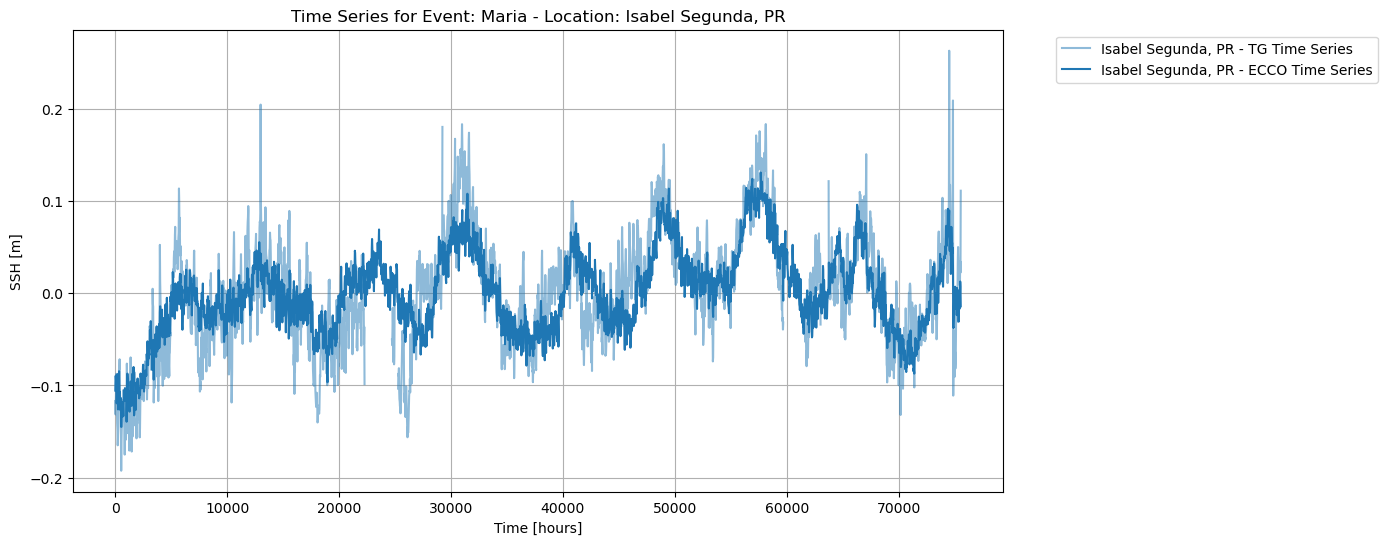

In [11]:
plot_time_series_specific_location(
    ar_allLoc_allEvent_tg, 
    ar_allLoc_allEvent_ec, 
    event_to_process, 
    location= 'Isabel Segunda, PR',
    xlab="Time [hours]", ylab="SSH [m]",
    normalize_zero=True,
    resample_tg=True,
    save_fig=True, plot_fig=True)